In [2]:
# imports 
import pandas as pd
import glob
import numpy as np 
import re 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from skbio.diversity.alpha import shannon

### make plots for the residual community

In [60]:
# read in the metadata
residual_community_metadata = pd.read_csv('../metadata/residual_community_metadata.csv')
order_dict = dict(zip(residual_community_metadata['FAME ID (leave blank)'], residual_community_metadata['Order'] ))

In [61]:
# read in the number of reads 
count_files = glob.glob('../data/prinseq_pass_counts/residual_community/*.counts')
counts = [pd.read_csv(c).columns[0] for c in count_files]
sample = [re.split('/', c)[-1][:10] for c in count_files]
count_dict = dict(zip(sample, counts))

In [62]:
# first residual community 
bracken_species_files = glob.glob('../data/bracken/residual_community/species_confidence_*/*.bracken')
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
bracken_species_shannon = []

# create a dictionary that maps names and taxonomy ids
name_taxid_map = {}

for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # save the taxid and names
    this_id_dict = dict(zip(table['name'], table['taxonomy_id']))
    name_taxid_map = name_taxid_map | this_id_dict
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    # add to the diversity table 
    bracken_species_shannon.append(shannon(table['fraction_total_reads']))
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1)

residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples, 'portion': bracken_species_portion, 'count': bracken_species_counts, 'shannon': bracken_species_shannon})
residual_species_rarefaction['order'] = [order_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('order')

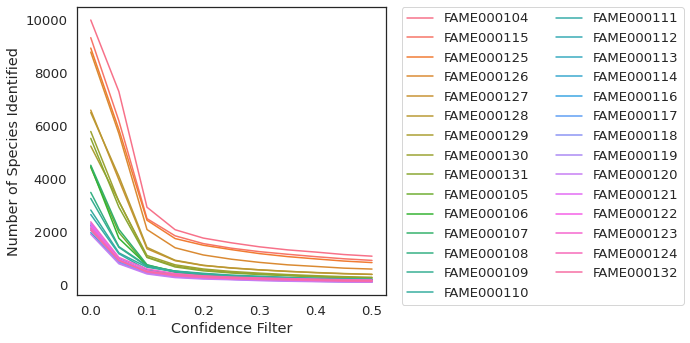

In [78]:
# Increase figure width
plt.figure(figsize=(10, 5))  # (width, height) in inches

# plot species data 
plot_df = residual_species_rarefaction
sns.set(style="white", font_scale=1.2)

ax = sns.lineplot(data=plot_df, y='count', x='portion', hue='sample')

plt.xlabel('Confidence Filter')
plt.ylabel('Number of Species Identified')

# Move legend to the side in two columns
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('../figures/residual_community_species_confidence_filter.png', dpi=300, bbox_inches='tight')
plt.show()


In [72]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/residual_community/genus_confidence_*/*')
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples, 'portion': bracken_genus_portion, 'count': bracken_genus_counts})
residual_genus_rarefaction['order'] = [order_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('order')

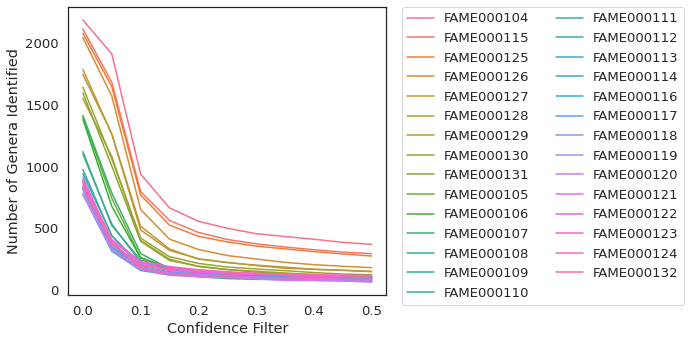

In [79]:
# Increase figure width
plt.figure(figsize=(10, 5))  # adjust width/height as needed

# plot genus data 
plot_df = residual_genus_rarefaction
sns.set(style="white", font_scale=1.2)

ax = sns.lineplot(data=plot_df, y='count', x='portion', hue='sample')

plt.xlabel('Confidence Filter')
plt.ylabel('Number of Genera Identified')

# Move legend to the side in two columns
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('../figures/residual_community_genera_confidence_filter.png', dpi=300, bbox_inches='tight')
plt.show()



<ipython-input-49-184531adc1a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_plot['distance'] = (confidence_plot['order'] -1)* 3
<ipython-input-49-184531adc1a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_plot['exp(shannon)'] = np.exp(confidence_plot['shannon'])


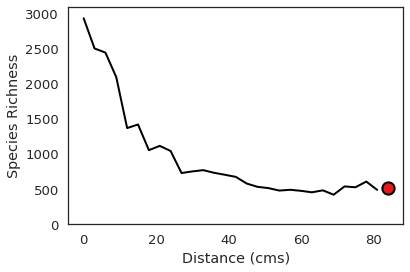

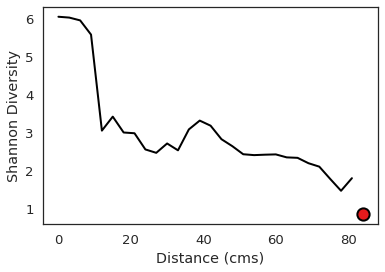

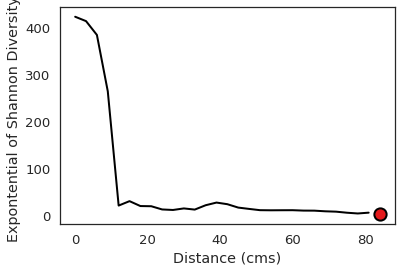

In [49]:
# set the confidence level to 0.1 
confidence_plot = residual_species_rarefaction[residual_species_rarefaction['portion'] == 0.1]
confidence_plot['distance'] = (confidence_plot['order'] -1)* 3 
confidence_plot['exp(shannon)'] = np.exp(confidence_plot['shannon']) 

plt.figure(figsize=(6, 4))
sns.set(style="white", font_scale=1.2)
sns.lineplot(data = confidence_plot[confidence_plot['order'] != 29].drop_duplicates(), x = 'distance', y = 'count', linewidth=2, color = 'black')
sns.scatterplot(data = confidence_plot[confidence_plot['order'] == 29].drop_duplicates(), x = 'distance', y = 'count', color = '#e41a1c', s = 150,  edgecolor='black', linewidth=2)
plt.ylim((0,3100))
plt.xlabel('Distance (cms)')
plt.ylabel('Species Richness')

# Save the figure to a file
plt.savefig('../figures/long_term_migration_species_richness_plot.png', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(6, 4))
sns.set(style="white", font_scale=1.2)
sns.lineplot(data = confidence_plot[confidence_plot['order'] != 29].drop_duplicates(), x = 'distance', y = 'shannon', linewidth=2, color = 'black')
sns.scatterplot(data = confidence_plot[confidence_plot['order'] == 29].drop_duplicates(), x = 'distance', y = 'shannon', color = '#e41a1c', s = 150,  edgecolor='black', linewidth=2)
#plt.ylim((0,3100))
plt.xlabel('Distance (cms)')
plt.ylabel('Shannon Diversity')

# Save the figure to a file
plt.savefig('../figures/long_term_migration_shannon_plot.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6, 4))
sns.set(style="white", font_scale=1.2)
sns.lineplot(data = confidence_plot[confidence_plot['order'] != 29].drop_duplicates(), x = 'distance', y = 'exp(shannon)', linewidth=2, color = 'black')
sns.scatterplot(data = confidence_plot[confidence_plot['order'] == 29].drop_duplicates(), x = 'distance', y = 'exp(shannon)', color = '#e41a1c', s = 150,  edgecolor='black', linewidth=2)
#plt.ylim((0,3100))
plt.xlabel('Distance (cms)')
plt.ylabel('Expontential of Shannon Diversity)')

# Save the figure to a file
plt.savefig('../figures/long_term_migration_expshannon_plot.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-50-55e248c61364>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  confidence_plot = residual_genus_rarefaction[residual_species_rarefaction['portion'] == 0.1]
<ipython-input-50-55e248c61364>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_plot['distance'] = (confidence_plot['order'] -1)* 3
<ipython-input-50-55e248c61364>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_plot['distance'] = (confidence_plot['order'] -1)*3


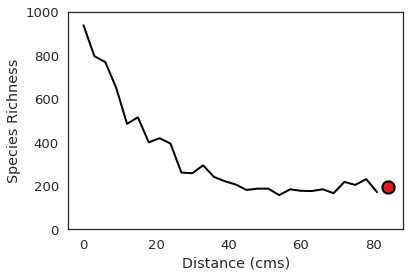

In [50]:
# set the confidence level to 0.1 
confidence_plot = residual_genus_rarefaction[residual_species_rarefaction['portion'] == 0.1]
confidence_plot['distance'] = (confidence_plot['order'] -1)* 3  

confidence_plot['distance'] = (confidence_plot['order'] -1)*3 

sns.set(style="white", font_scale=1.2)
sns.lineplot(data = confidence_plot[confidence_plot['order'] != 29].drop_duplicates(), x = 'distance', y = 'count', linewidth=2, color = 'black')
sns.scatterplot(data = confidence_plot[confidence_plot['order'] == 29].drop_duplicates(), x = 'distance', y = 'count', color = '#e41a1c', s = 150,  edgecolor='black', linewidth=2)
plt.ylim((0,1000))
plt.xlabel('Distance (cms)')
plt.ylabel('Species Richness')

# Save the figure to a file
plt.savefig('../figures/long_term_migration_genus_richness_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## take a confidence level of 0.1 and then apply this to build rarefaction curves

In [51]:
# first residual community 
#bracken_species_files = glob.glob('/home/grig0076/scratch/TubePaper_2023/residual_community_Tube_fastq/krakefaction_paired_trimnami_2024/confidence_0.1/repeat/*.bracken')
bracken_species_files = glob.glob('../data/bracken/residual_community/rarefaction_confidence_0.1/*.bracken.species')
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
bracken_species_table_abund = pd.DataFrame()
for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0] 
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd = dd[dd['new_est_reads'] > 0] # only include the reads that are present # need to edit this one here 
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1) 
        bracken_species_table_abund = pd.concat([bracken_species_table_abund,dd/int(count_dict.get(dd.columns[0]))], axis = 1) 

residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples,'count': bracken_species_counts, 'portion': bracken_species_portion})
residual_species_rarefaction['order'] = [order_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('order')

In [52]:
# process the dable for use in icamp 
bracken_species_table_icamp = bracken_species_table.copy()
bracken_species_table_icamp.index = [name_taxid_map.get(t) for t in bracken_species_table.index]

bracken_species_table_totalreads = pd.DataFrame.from_dict(count_dict, orient='index').T[bracken_species_table.columns]
bracken_species_table_unclassified = bracken_species_table_totalreads.astype(int) - pd.DataFrame(bracken_species_table.sum()).T.astype(int)
bracken_species_table_icamp = pd.concat([bracken_species_table_icamp, bracken_species_table_unclassified]).fillna(0)

bracken_species_table_icamp.to_csv('../output_files/residual_community_bracken_species_confidence_0.1_icamp_formatted.tsv', sep='\t' )

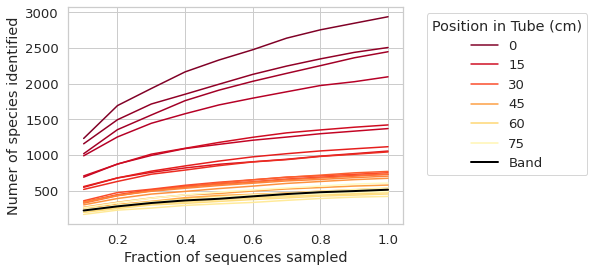

In [58]:
# Change axes to position from innoculation site 
residual_species_rarefaction['distance'] = (residual_species_rarefaction['order'] -1)*3 
sns.set(font_scale=1.2, style = 'whitegrid')
sns.lineplot(data = residual_species_rarefaction[residual_species_rarefaction['order'] < 29], x = 'portion', y = 'count', hue = 'distance', palette = 'YlOrRd_r')
sns.lineplot(data = residual_species_rarefaction[residual_species_rarefaction['order'] == 29], x = 'portion', y = 'count', color = 'black', linewidth=2, dashes = True)

# Create custom legend handle for the band
band_line = mlines.Line2D(
    [], [], color='black', linewidth=2, linestyle='-', label='Band'
)

# Add legend, combining auto handles with custom one
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(band_line)
labels.append('Band')

plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Numer of species identified')
plt.legend(
    handles, labels,
    bbox_to_anchor=(1.05, 1), loc='upper left', title='Position in Tube (cm)'
)


plt.savefig('../figures/residual_community_species_rarefaction.png', dpi=300,  bbox_inches='tight') 
plt.show()

In [21]:
bracken_species_table.to_csv('../output_files/residual_community_bracken_species_confidence_0.1.tsv', sep = '\t')
bracken_species_table_abund.to_csv('../output_files/residual_community_bracken_species_abund_confidence_0.1.tsv', sep = '\t')

In [22]:
## Need to delete the output with the stacked flags 

In [23]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/residual_community/rarefaction_confidence_0.1/*.bracken.genus')
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
bracken_genus_table_abund = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)
        bracken_genus_table_abund = pd.concat([bracken_genus_table_abund,dd/int(count_dict.get(dd.columns[0]))], axis = 1)

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples,'count': bracken_genus_counts, 'portion': bracken_genus_portion})
residual_genus_rarefaction['order'] = [order_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('order')

In [ ]:
residual_genus_rarefaction['distance'] = (residual_genus_rarefaction['order'] -1)*3 
sns.set(font_scale=1.2, style = 'whitegrid')
sns.lineplot(data = residual_genus_rarefaction[residual_genus_rarefaction['order'] < 29], x = 'portion', y = 'count', hue = 'distance', palette = 'YlOrRd_r')
sns.lineplot(data = residual_genus_rarefaction[residual_genus_rarefaction['order'] == 29], x = 'portion', y = 'count', color = 'black', linewidth=2, dashes = True)

plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Numer of genera identified')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = 'Position in Tube (cm)')
plt.savefig('../figures/residual_community_genera_rarefaction.png', dpi=300,  bbox_inches='tight')
plt.show()

In [17]:
bracken_genus_table.to_csv('../output_files/residual_community_bracken_genus_confidence_0.1.tsv', sep = '\t')
bracken_genus_table_abund.to_csv('../output_files/residual_community_bracken_genus_abund_confidence_0.1.tsv', sep = '\t')

In [30]:
this_sample

,FAME000132,rank,rank_log,FAME000132_log
name,,,,
Lelliottia amnigena,0.901084,1,0.000000,-0.045235
Leclercia adecarboxylata,0.032371,2,0.301030,-1.489839
Enterobacter sp. 638,0.013452,3,0.477121,-1.871219
Leclercia sp. 119287,0.012043,4,0.602060,-1.919251
Leclercia sp. G3L,0.005576,5,0.698970,-2.253713
...,...,...,...,...
Deinococcus wulumuqiensis,NaN,4684,3.670617,NaN
Spiroplasma endosymbiont of Crioceris asparagi,NaN,4685,3.670710,NaN
Aequorivita sp. Ant34-E75,NaN,4686,3.670802,NaN


In [37]:
this_sample[this_sample[this_sample.columns[-1]] <-2.5].iloc[0]['rank']

9.0

### Investigate the rare taxa 

FAME000104: number of rare taxa: 2896
Rank when moving to rare: 43.0
FAME000115: number of rare taxa: 2461
Rank when moving to rare: 47.0
FAME000125: number of rare taxa: 2402
Rank when moving to rare: 47.0
FAME000126: number of rare taxa: 2057
Rank when moving to rare: 41.0
FAME000127: number of rare taxa: 1351
Rank when moving to rare: 22.0
FAME000128: number of rare taxa: 1404
Rank when moving to rare: 20.0
FAME000129: number of rare taxa: 1037
Rank when moving to rare: 21.0
FAME000130: number of rare taxa: 1101
Rank when moving to rare: 18.0
FAME000131: number of rare taxa: 1029
Rank when moving to rare: 17.0
FAME000105: number of rare taxa: 714
Rank when moving to rare: 18.0
FAME000106: number of rare taxa: 735
Rank when moving to rare: 20.0
FAME000107: number of rare taxa: 756
Rank when moving to rare: 17.0
FAME000108: number of rare taxa: 718
Rank when moving to rare: 17.0
FAME000109: number of rare taxa: 689
Rank when moving to rare: 18.0
FAME000110: number of rare taxa: 662
Ra

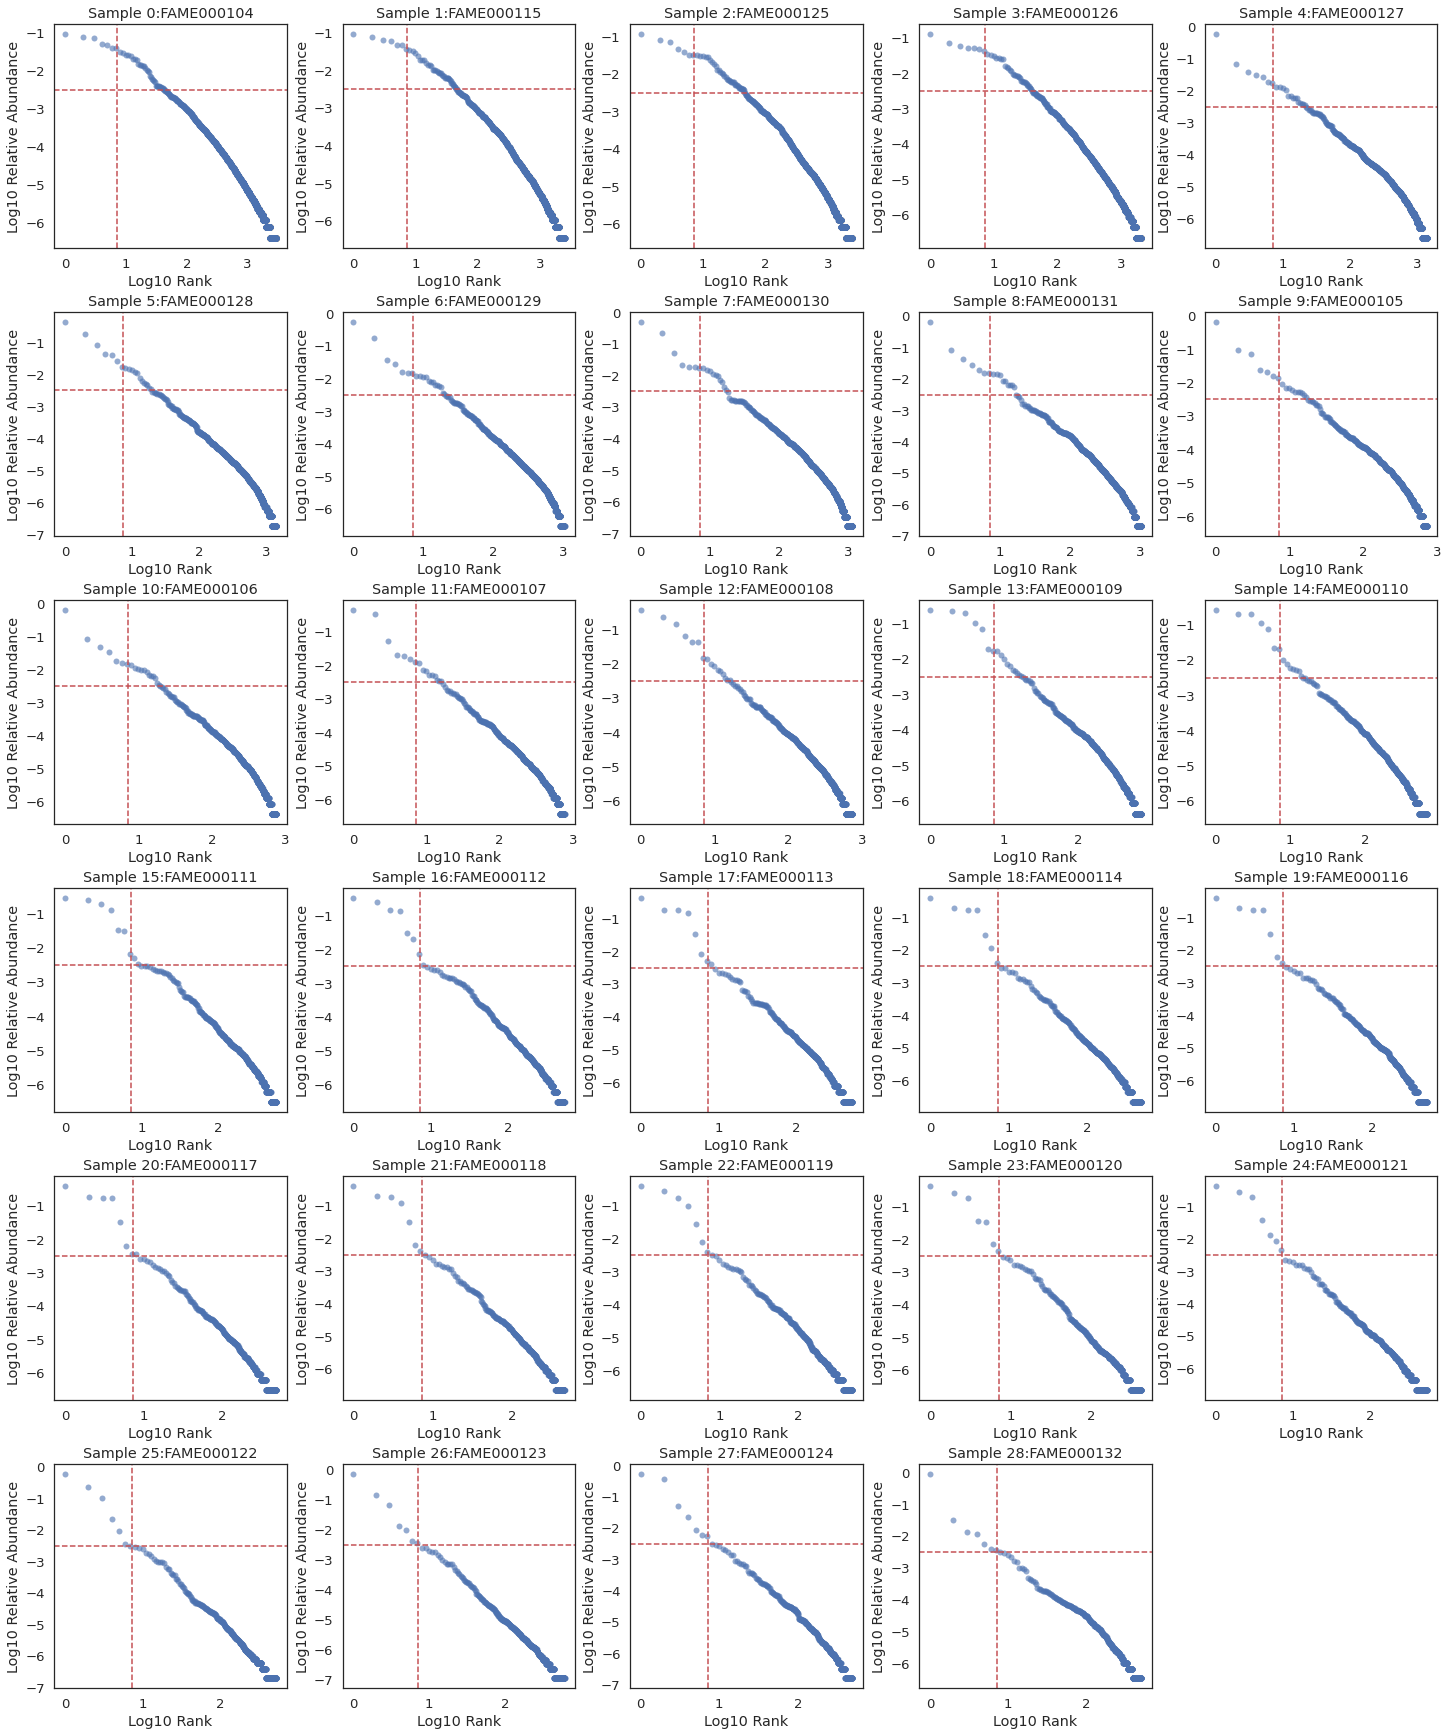

In [42]:
samples = list(order_dict.keys()) 
num_rare_taxa = [] 
bracken_species_table_abund = bracken_species_table / bracken_species_table.sum() 

num_samples = len(samples)
num_cols = 5  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_samples / num_cols))  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), constrained_layout=True)

for idx, f in enumerate(samples): 
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]

    this_sample = bracken_species_table_abund[[f]] 
    this_sample = this_sample[this_sample[f] != 0].sort_values(f, ascending=False)
    this_sample['rank'] = [i + 1 for i in range(len(this_sample))]
    this_sample['rank_log'] = np.log10(this_sample['rank']) 
    this_sample[f + '_log'] = np.log10(this_sample[f])

    sns.scatterplot(data=this_sample, x='rank_log', y=f + '_log', linewidth=0, alpha=0.6, ax=ax)
    ax.axhline(y=-2.5, color='r', linestyle='--')  # Adding dashed line at y=-2.5
    ax.axvline(x=0.86, color='r', linestyle='--') # Corresponds to a rank of 7
    
    ax.set_xlabel('Log10 Rank')
    ax.set_ylabel('Log10 Relative Abundance')
    ax.set_title(f'Sample {idx}:{f}')

    num_rare = len(this_sample[this_sample[f + '_log'] < -2.5])
    print(f + ': number of rare taxa: ' + str(num_rare))
    print('Rank when moving to rare: ' + str(this_sample[this_sample[this_sample.columns[-1]] <-2.5].iloc[0]['rank']))
    num_rare_taxa.append(num_rare) 

# Hide any unused subplots
for idx in range(num_samples, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])


plt.show()

num_rare_tax_dict = dict(zip(samples, num_rare_taxa))

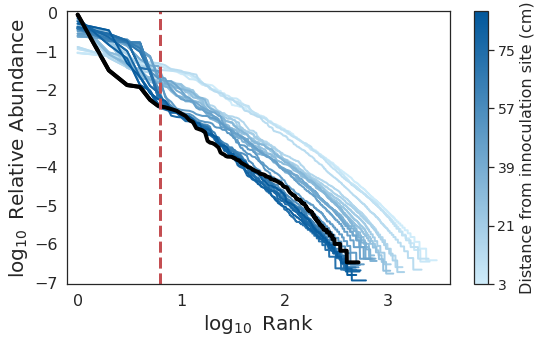

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a gradient color map from light to dark
cmap = LinearSegmentedColormap.from_list("gradient", ["#CFECFA", "#01579B"])

# Create a wider figure
fig, ax = plt.subplots(figsize=(8, 5))  # Increased width for better layout
sns.set(style="white", font_scale=1.2)

# Normalize sample indices to map them to the color gradient
norm = plt.Normalize(vmin=0, vmax=len(samples) - 1)

# Plot each sample
for idx, f in enumerate(samples):
    this_sample = bracken_species_table_abund[[f]]
    this_sample = this_sample[this_sample[f] != 0].sort_values(f, ascending=False)
    this_sample['rank'] = [i + 1 for i in range(len(this_sample))]
    this_sample['rank_log'] = np.log10(this_sample['rank'])
    this_sample[f + '_log'] = np.log10(this_sample[f])

    # Map index to color
    if idx == len(samples) - 1:  # Last sample
        color = 'black'
        linewidth = 4  # Thicker line for the last sample
        label = f  # Last sample label
    else:
        color = cmap(norm(idx))
        linewidth = 2
        label = f  # Label for other samples

    # Plot line
    sns.lineplot(data=this_sample, x='rank_log', y=f + '_log', ax=ax, color=color, linewidth=linewidth, label=label, legend=False)

for idx, f in enumerate(samples):
    this_sample = bracken_species_table_abund[[f]]
    this_sample = this_sample[this_sample[f] != 0].sort_values(f, ascending=False)
    this_sample['rank'] = [i + 1 for i in range(len(this_sample))]
    this_sample['rank_log'] = np.log10(this_sample['rank'])
    this_sample[f + '_log'] = np.log10(this_sample[f])

    # Filter to only points before hitting x or y thresholds
    x_cutoff = 0.8
    y_cutoff = -2.5

    # Apply both conditions
    valid_data = this_sample[
        (this_sample['rank_log'] <= x_cutoff) &
        (this_sample[f + '_log'] >= y_cutoff)
    ]

    # At least 2 points needed to draw a line
    if len(valid_data) >= 2:
        x_vals = valid_data['rank_log'].values
        y_vals = valid_data[f + '_log'].values

        # Color and style
        if idx == len(samples) - 1:
            color = 'black'
            linewidth = 4
            label = f
        else:
            color = cmap(norm(idx))
            linewidth = 2
            label = f

        # Plot manually for more control
        ax.plot(x_vals, y_vals, color=color, linewidth=linewidth, label=label)


# Set labels and limits
#ax.axhline(y=-2.5, color='r', linestyle='--', linewidth=3) 
ax.axvline(x=0.8, color='r', linestyle='--', linewidth=3) # Corresponds to a rank of 7
ax.set_xlim((-0.1, 3.6))
ax.set_ylim((bracken_species_table_abund.apply(lambda x: np.log10(x[x != 0].min())).min() - 0.1, 
             bracken_species_table_abund.apply(lambda x: np.log10(x.max())).max() + 0.1))
#ax.set_xlabel('Log10 Rank', fontsize=20)
#ax.set_ylabel('Log10 Relative Abundance', fontsize=20)
plt.ylabel(r"$\log_{10}$ Relative Abundance", fontsize=20)
plt.xlabel(r"$\log_{10}$ Rank", fontsize=20)

# Increase the size of x and y ticks
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Create a colorbar as a gradient key
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")

# Generate rounded tick values
rounded_ticks = np.arange(0, len(samples) + 1, step=round(len(samples) / 5))  # Adjust the step for spacing
transformed_ticks = 3 * (rounded_ticks + 1)

# Set the ticks and labels to be more rounded numbers
cbar.set_ticks(rounded_ticks)
cbar.set_ticklabels([f'{int(tick)}' for tick in transformed_ticks])

cbar.set_label('Distance from innoculation site (cm)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Adjust layout to prevent white space
plt.subplots_adjust(right=0.75)  # Adjust the right margin to fit the colorbar
plt.tight_layout()
plt.savefig('../figures/residual_community_rank_abundance.png', dpi=300)
plt.show()


### Make plots for long-term migration

In [3]:
long_term_metadata = pd.read_csv('../metadata/long_term_migration_metadata.csv')
location_dict = dict(zip(long_term_metadata['FAME'], long_term_metadata['location']))

In [4]:
# read in the number of reads 
count_files = glob.glob('../data/prinseq_pass_counts/long_term_migration/prinseq_pass_counts/*.counts')
counts = [pd.read_csv(c).columns[0] for c in count_files]
sample = [re.split('/', c)[-1][:10] for c in count_files]
count_dict = dict(zip(sample, counts))

In [5]:
# long term migration 
bracken_species_files = glob.glob('../data/bracken/long_term_migration/species_confidence_*/*bracken' )
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        print(dd)
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1)
        
residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples, 'portion': bracken_species_portion, 'count': bracken_species_counts})
residual_species_rarefaction['location'] = [location_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('location')

In [6]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/long_term_migration/genus_confidence_*/*bracken.genus' )
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples, 'portion': bracken_genus_portion, 'count': bracken_genus_counts})
residual_genus_rarefaction['location'] = [location_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('location')

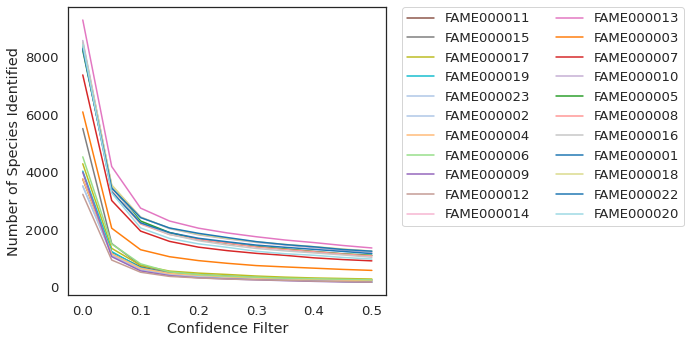

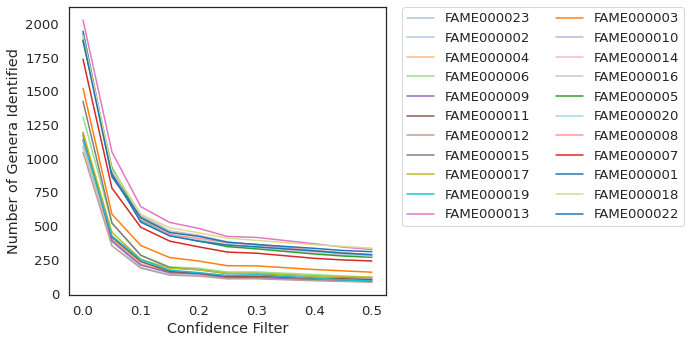

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the unique samples across both datasets
all_samples = list(set(residual_species_rarefaction['sample']).union(
                   set(residual_genus_rarefaction['sample'])))

# Make a color palette and assign colors to each sample
palette = sns.color_palette("tab20", len(all_samples))  # or another palette
sample_colors = dict(zip(sorted(all_samples), palette))

# ---------- Species Plot ----------
plt.figure(figsize=(10, 5))

sns.set(style="white", font_scale=1.2)

ax = sns.lineplot(data=residual_species_rarefaction, 
                  y='count', x='portion', hue='sample',
                  palette=sample_colors)

plt.xlabel('Confidence Filter')
plt.ylabel('Number of Species Identified')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('../figures/long_term_migration_species_confidence_filter.png',
            dpi=300, bbox_inches='tight')
plt.show()

# ---------- Genus Plot ----------
plt.figure(figsize=(10, 5))

sns.set(style="white", font_scale=1.2)

ax = sns.lineplot(data=residual_genus_rarefaction, 
                  y='count', x='portion', hue='sample',
                  palette=sample_colors)

plt.xlabel('Confidence Filter')
plt.ylabel('Number of Genera Identified')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('../figures/long_term_migration_genera_confidence_filter.png',
            dpi=300, bbox_inches='tight')
plt.show()


### With a confidence value of 0.1 attempt to make the plot

In [8]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/long_term_migration/rarefaction_confidence_0.1/*.bracken.genus')
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
bracken_genus_table_abund = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)
        bracken_genus_table_abund = pd.concat([bracken_genus_table,dd/int(count_dict.get(dd.columns[0]))], axis = 1) 

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples,'count': bracken_genus_counts, 'portion': bracken_genus_portion})
residual_genus_rarefaction['location'] = [location_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('location')

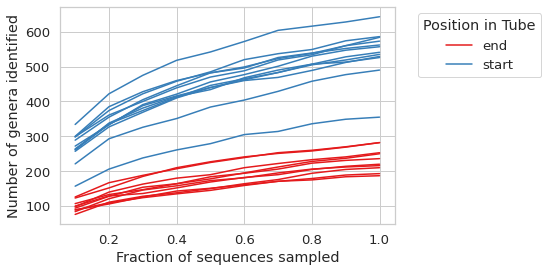

In [35]:

# Adjust the font scale and style
sns.set(font_scale=1.2, style='whitegrid')

# Define a custom color palette
custom_palette = {
    'end': '#e41a1c',
    'start': '#377eb8'
}

# Create the lineplot
sns.lineplot(data=residual_genus_rarefaction, x='portion', y='count', hue='location', style='sample', dashes=False, palette=custom_palette)

# Set the labels
plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Number of genera identified')

# Adjust the legend to only show 'location'
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = sorted(set(labels))
location_handles = [handles[labels.index(label)] for label in unique_labels if label in custom_palette.keys()]
location_labels = sorted(custom_palette.keys())

# Create a new legend with only 'location'
plt.legend(location_handles, location_labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Position in Tube')
plt.savefig('../figures/long_term_migration_genera_rarefaction.png', dpi=300,  bbox_inches='tight')

# Show the plot
plt.show()


In [9]:
bracken_genus_table.to_csv('../output_files/long_term_migration_bracken_genus_confidence_0.1.tsv', sep = '\t')
bracken_genus_table_abund.to_csv('../output_files/long_term_migration_bracken_genus_abund_confidence_0.1.tsv', sep = '\t')

In [10]:
# first residual community 
bracken_species_files = glob.glob('../data/bracken/long_term_migration/rarefaction_confidence_0.1/*.bracken.species')
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
bracken_species_table_abund = pd.DataFrame()
for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1)
        bracken_species_table_abund = pd.concat([bracken_species_table_abund,dd/int(count_dict.get(dd.columns[0]))], axis = 1)

residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples,'count': bracken_species_counts, 'portion': bracken_species_portion})
residual_species_rarefaction['location'] = [location_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('location')

In [14]:
# create a dictionary that maps names and taxonomy ids - needed to make the icamp table 
name_taxid_map = {}

for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # save the taxid and names
    this_id_dict = dict(zip(table['name'], table['taxonomy_id']))
    name_taxid_map = name_taxid_map | this_id_dict

In [22]:
# process the dable for use in icamp 
bracken_species_table_icamp = bracken_species_table.copy()
bracken_species_table_icamp.index = [name_taxid_map.get(t) for t in bracken_species_table.index]

bracken_species_table_totalreads = pd.DataFrame.from_dict(count_dict, orient='index').T[bracken_species_table.columns]
bracken_species_table_unclassified = bracken_species_table_totalreads.astype(int) - pd.DataFrame(bracken_species_table.sum()).T.astype(int)
bracken_species_table_icamp = pd.concat([bracken_species_table_icamp, bracken_species_table_unclassified]).fillna(0)

bracken_species_table_icamp.to_csv('../output_files/long_term_migration_bracken_species_confidence_0.1_icamp_formatted.tsv', sep='\t' )

In [21]:
bracken_species_table_icamp

,FAME000001,FAME000002,FAME000003,FAME000004,FAME000005,FAME000006,FAME000007,FAME000008,FAME000009,FAME000010,...,FAME000013,FAME000014,FAME000015,FAME000016,FAME000017,FAME000018,FAME000019,FAME000020,FAME000022,FAME000023
573,1206949.0,37832.0,530173.0,23817.0,2351415.0,22097.0,456374.0,1110673.0,10289.0,1406574.0,...,1312929.0,1005416.0,15166.0,529481.0,19174.0,809012.0,26844.0,432473.0,968351.0,6830.0
1463165,263591.0,1116.0,56121.0,2966.0,234686.0,423.0,50738.0,161702.0,1121.0,350534.0,...,195189.0,147175.0,17745.0,43479.0,752.0,46934.0,1767.0,23961.0,69624.0,213.0
1134687,164073.0,1656.0,51272.0,6442.0,355293.0,322.0,78745.0,198328.0,715.0,276177.0,...,266987.0,199307.0,531.0,130679.0,517.0,190141.0,1822.0,83756.0,219977.0,243.0
2675726,4241.0,2.0,1529.0,4.0,3510.0,7.0,582.0,1775.0,2.0,2059.0,...,1279.0,1873.0,8.0,5141.0,3.0,2320.0,15.0,3896.0,5174.0,5.0
2675710,14513.0,2144.0,5011.0,271.0,10697.0,40.0,2417.0,9267.0,0.0,7185.0,...,15543.0,10621.0,827.0,33435.0,38.0,23640.0,27.0,16909.0,33770.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2844380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
554406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
285729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


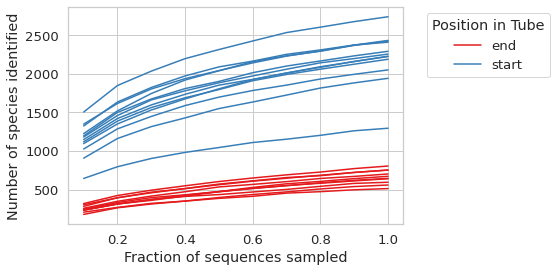

In [41]:
# Adjust the font scale and style
sns.set(font_scale=1.2, style='whitegrid')

# Define a custom color palette
custom_palette = {
    'end': '#e41a1c',
    'start': '#377eb8'
}

# Create the lineplot
sns.lineplot(data=residual_species_rarefaction, x='portion', y='count', hue='location', style='sample', dashes=False, palette=custom_palette)

# Set the labels
plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Number of species identified')

# Adjust the legend to only show 'location'
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = sorted(set(labels))
location_handles = [handles[labels.index(label)] for label in unique_labels if label in custom_palette.keys()]
location_labels = sorted(custom_palette.keys())

# Create a new legend with only 'location'
plt.legend(location_handles, location_labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Position in Tube')
plt.savefig('../figures/long_term_migration_species_rarefaction.png', dpi=300,  bbox_inches='tight')

# Show the plot
plt.show()

In [19]:
bracken_species_table.to_csv('../output_files/long_term_migration_bracken_species_confidence_0.1.tsv', sep = '\t')
bracken_species_table_abund.to_csv('../output_files/long_term_migration_bracken_species_abund_confidence_0.1.tsv', sep = '\t')

In [20]:
residual_species_rarefaction[residual_species_rarefaction['portion'] == 1.0].sort_values('count', axis=0, ascending = False)

,sample,count,portion,location
120,FAME000013,2741,1.0,start
90,FAME000010,2434,1.0,start
170,FAME000018,2425,1.0,start
200,FAME000022,2411,1.0,start
40,FAME000005,2293,1.0,start
130,FAME000014,2257,1.0,start
0,FAME000001,2230,1.0,start
150,FAME000016,2225,1.0,start
70,FAME000008,2190,1.0,start
190,FAME000020,2052,1.0,start


In [21]:
residual_genus_rarefaction[residual_genus_rarefaction['portion'] == 1.0].sort_values('count', axis=0, ascending = False)

,sample,count,portion,location
120,FAME000013,643,1.0,start
170,FAME000018,586,1.0,start
150,FAME000016,584,1.0,start
90,FAME000010,573,1.0,start
200,FAME000022,562,1.0,start
70,FAME000008,557,1.0,start
40,FAME000005,541,1.0,start
190,FAME000020,535,1.0,start
0,FAME000001,529,1.0,start
130,FAME000014,526,1.0,start


# Rank abundance curves
Make some rank abundance curves to support the output 

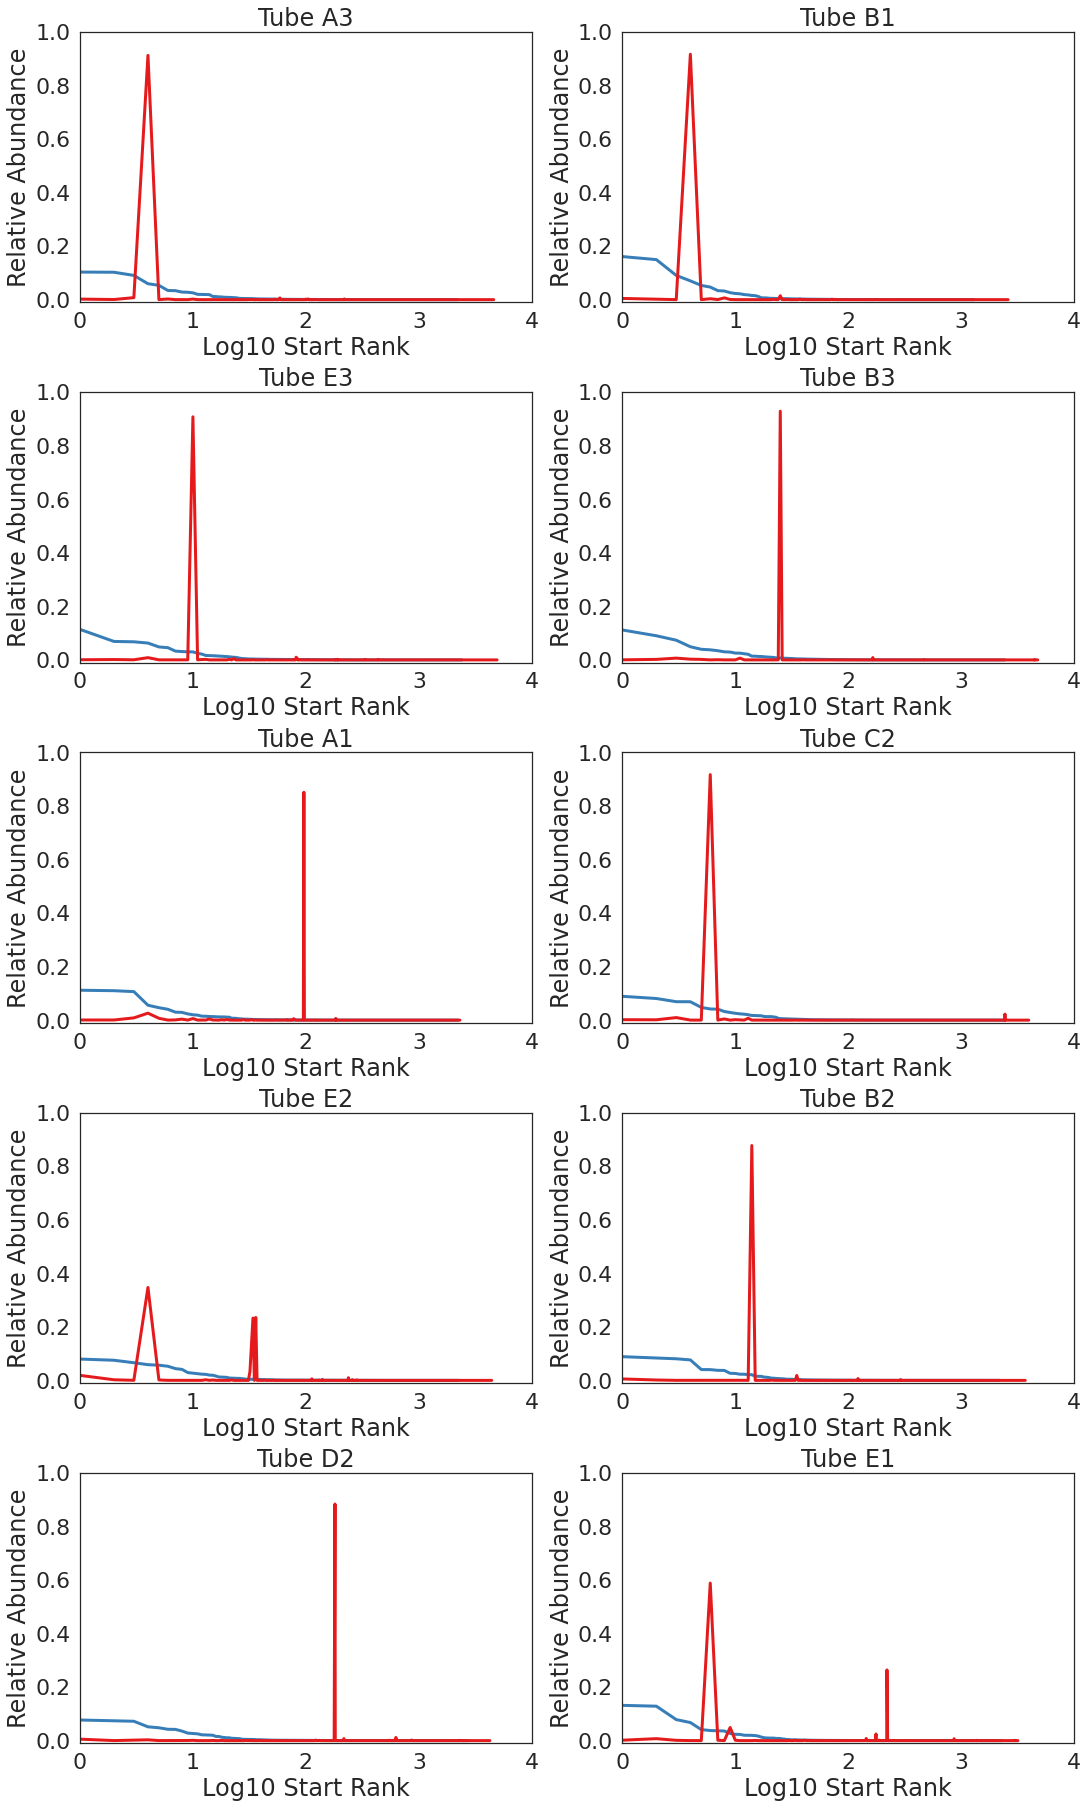

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tubes = list(set(long_term_metadata['tube'])) 
#norm_abund = bracken_species_table / bracken_species_table.sum()
norm_abund = bracken_species_table_abund

# Set the figure size 
sns.set(style="white", font_scale=2.0)

num_tubes = len(tubes) - 2
num_cols = 2  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_tubes / num_cols))  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)

for idx, t in enumerate([t for t in tubes if t not in ['D3', 'A2']]): 
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]

    # Get the samples that are in this tube 
    tube_samples = long_term_metadata[long_term_metadata['tube'] == t]['FAME'].to_list() 
    if len(tube_samples) > 1: 
        tube_samples_location = [location_dict.get(f) for f in tube_samples]
        start_tube = tube_samples[tube_samples_location.index('start')] 
        end_tube = tube_samples[tube_samples_location.index('end')] 
        
        # Make rank abundance table 
        tube_abundances = norm_abund[[start_tube, end_tube]].sort_values(start_tube, ascending=False) 
        tube_abundances['start_rank'] = [i + 1 for i in range(len(tube_abundances))]
        tube_abundances['start_rank_log'] = np.log10(tube_abundances['start_rank'])
        
        # Log transform the abundances 
        tube_abundances[start_tube + '_log'] = np.log10(tube_abundances[start_tube])
        tube_abundances[end_tube + '_log'] = np.log10(tube_abundances[end_tube])
        
        sns.lineplot(data=tube_abundances, x='start_rank_log', y=start_tube, ax=ax, linewidth=3, color = '#377eb8')
        sns.lineplot(data=tube_abundances, x='start_rank_log', y=end_tube, ax=ax, linewidth=3, color = '#e41a1c')
        
        ax.set_xlabel('Log10 Start Rank')
        ax.set_ylabel('Relative Abundance')
        ax.set_xlim(0, 4)
        ax.set_ylim(-0.01, 1)
        ax.set_title(f'Tube {t}')
    else:
        print(t)
        ax.set_visible(False)  # Hide the unused subplot

# Hide any unused subplots
for idx in range(num_tubes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])

# Save the figure as a PNG file
plt.savefig('../figures/long_term_migration_rank_abundance_plots.png')

plt.show()


## Make a rarefaction curve from the QIIME2 16S data 

In [141]:
qiime = pd.read_csv('../data/16S/observed_features.csv')
qiime['round'] = [i[1] if 'Inn' not in i else i[-1] for i in qiime['sample-id']]

In [143]:
qiime

,sample-id,depth-1_iter-1,depth-1_iter-2,depth-1_iter-3,depth-1_iter-4,depth-1_iter-5,depth-1_iter-6,depth-1_iter-7,depth-1_iter-8,depth-1_iter-9,...,depth-29211_iter-6,depth-29211_iter-7,depth-29211_iter-8,depth-29211_iter-9,depth-29211_iter-10,BarcodeSequence,LinkerPrimerSequence,Tube,Time,round
0,A3-12h,1,1,1,1,1,1,1,1,1,...,212,212,213,213,209,CGTACAGGAA,TAGGTTCTCT,A,12h,3
1,A3-15h,1,1,1,1,1,1,1,1,1,...,156,156,155,156,156,TTCGGTGTGA,GAACAAGTAT,A,15h,3
2,A3-18h,1,1,1,1,1,1,1,1,1,...,159,160,159,159,159,GAATACCTAT,ACAATAGAGT,A,18h,3
3,A3-6h,1,1,1,1,1,1,1,1,1,...,252,252,251,251,250,GAACGCAATA,ATCTTACTGT,A,6h,3
4,A3-9h,1,1,1,1,1,1,1,1,1,...,296,298,293,300,297,AGGCAGCTCT,CGGCTAACGT,A,9h,3
5,B2-12h,1,1,1,1,1,1,1,1,1,...,178,177,177,177,178,CTCGAATATA,GAGATGTCGA,B,12h,2
6,B2-15h,1,1,1,1,1,1,1,1,1,...,160,160,160,159,160,ACGGTCCAAC,TCTTACATCA,B,15h,2
7,B2-18h,1,1,1,1,1,1,1,1,1,...,170,171,171,171,171,CACTCAATTC,TTAAGTTGTG,B,18h,2
8,B2-9h,1,1,1,1,1,1,1,1,1,...,238,238,238,238,238,ATGTTGTTGG,CAATCTATGA,B,9h,2
9,B3-12h,1,1,1,1,1,1,1,1,1,...,223,222,222,223,221,ATAGCGGAAT,GCGCAGAGTA,B,12h,3


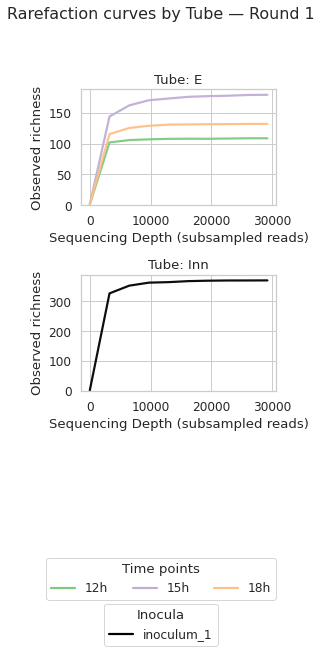

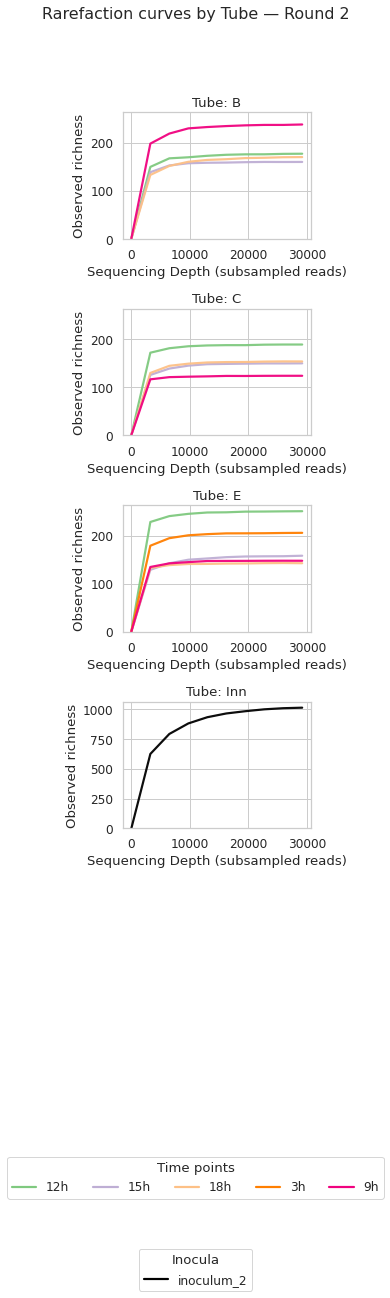

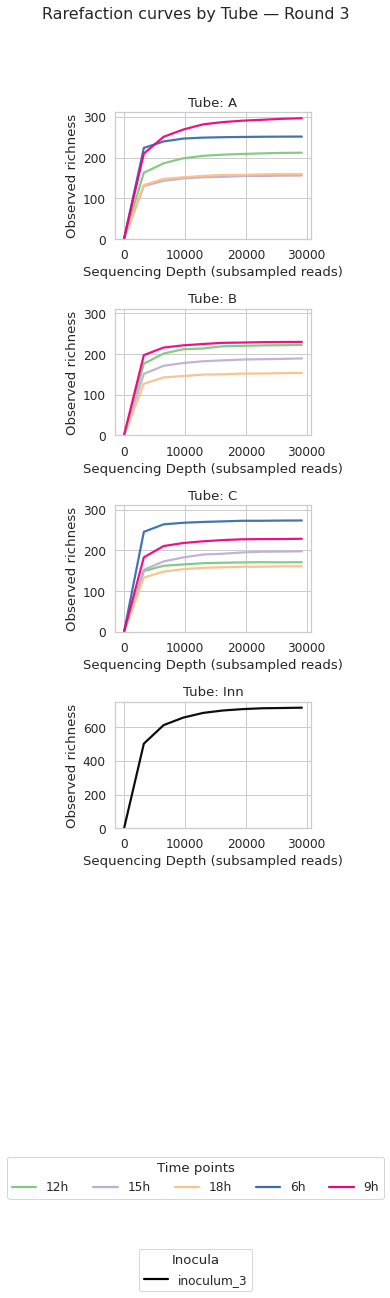

In [157]:
import os, re, math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- assumes your DataFrame is already loaded as `qiime` ----
# e.g., qiime = pd.read_csv("...")

# ========== CONFIG ==========
LINEWIDTH  = 2.2          # thicker lines for clarity
COLS       = 1            # subplots per row
ROW_HEIGHT = 4.0          # inches per row (figure height scales automatically)
SAVE_DIR   = "../figures" # output folder for images

# Your custom 8-color palette (3h = bright orange instead of pale yellow)
CUSTOM_COLORS = [
    "#7fc97f",  # green
    "#beaed4",  # purple
    "#fdc086",  # peach
    "#ff7f00",  # bright orange (3h)
    "#386cb0",  # blue
    "#f0027f",  # magenta
    "#bf5b17",  # brown
    "#666666"   # gray
]
# ===========================

os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Identify rarefaction columns
depth_iter_cols = [c for c in qiime.columns if re.match(r"^depth-\d+_iter-\d+$", c)]
if not depth_iter_cols:
    raise ValueError("No columns like depth-<n>_iter-<k> found.")

# 2) Melt + parse depth/iter
long = qiime.melt(
    id_vars=[c for c in qiime.columns if c not in depth_iter_cols],
    value_vars=depth_iter_cols,
    var_name="depth_iter", value_name="obs"
)
parsed = long["depth_iter"].str.extract(r"^depth-(\d+)_iter-(\d+)$").astype(int)
long["depth"] = parsed[0]
long["iter"]  = parsed[1]

# 3) Average iterations per sample & depth
per_sample = (long
    .groupby(["sample-id", "Tube", "Time", "round", "depth"], as_index=False)["obs"]
    .mean()
    .rename(columns={"obs": "observed"})
)

# 4) Build time/inoculum labels (Inn_R# -> inoculum_#)
def time_lbl(row):
    if str(row["Tube"]).lower() == "inn":
        m = re.search(r"R(\d+)", str(row["Time"]))
        n = m.group(1) if m else ""
        return f"inoculum_{n}" if n else "inoculum"
    return str(row["Time"])

per_sample["time_lbl"] = per_sample.apply(time_lbl, axis=1)

# 5) GLOBAL palette so (non-inoculum) times are consistent across rounds & tubes
sns.set(style="whitegrid", font_scale=1.1)
all_labels = sorted(per_sample["time_lbl"].unique(), key=lambda x: (x.startswith("inoculum"), x))
# Only time-point colors come from the palette; inoculum will be forced to black when plotting
reps = math.ceil(len(all_labels) / len(CUSTOM_COLORS))
palette = (CUSTOM_COLORS * reps)[:len(all_labels)]
GLOBAL_CMAP = dict(zip(all_labels, palette))

# 6) Helper to plot a single round
def plot_round(rval):
    df_r = per_sample[per_sample["round"] == rval]
    if df_r.empty:
        return

    # tubes in this round (nice order if present)
    order_key = {"A":0, "B":1, "C":2, "D":3, "E":4, "Inn":5}
    tubes = sorted(df_r["Tube"].unique(), key=lambda t: order_key.get(str(t), 99))

    n = len(tubes)
    cols = COLS
    rows = math.ceil(n / cols)
    fig_height = max(ROW_HEIGHT * rows, 3.0)

    fig, axes = plt.subplots(rows, cols, figsize=(4, fig_height), sharey=False)
    axes = axes.flatten()

    # group-wise y-limits (within this round)
    non_inn = df_r[df_r["Tube"].str.lower() != "inn"]
    inn_only = df_r[df_r["Tube"].str.lower() == "inn"]
    yl_noninn = (0, non_inn["observed"].max() * 1.05) if not non_inn.empty else (0, 1)
    yl_inn    = (0, inn_only["observed"].max() * 1.05) if not inn_only.empty else (0, 1)

    # draw each tube panel
    for i, tube in enumerate(tubes):
        ax = axes[i]
        data_t = df_r[df_r["Tube"] == tube].sort_values("depth")

        # draw lines (one per sample-id), colored by time; inoculum lines are black
        for t_lbl, grp_t in data_t.groupby("time_lbl"):
            is_inoculum = t_lbl.startswith("inoculum")
            this_color = "black" if is_inoculum else GLOBAL_CMAP[t_lbl]

            for sid, grp in grp_t.groupby("sample-id", sort=False):
                ax.plot(grp["depth"], grp["observed"],
                        lw=LINEWIDTH, alpha=0.95,
                        color=this_color, label=t_lbl)

        ax.set_title(f"Tube: {tube}")
        ax.set_xlabel("Sequencing Depth (subsampled reads)")
        ax.set_ylabel("Observed richness")
        ax.xaxis.set_tick_params(which="both", labelbottom=True)
        ax.set_ylim(*(yl_inn if str(tube).lower() == "inn" else yl_noninn))

    # remove truly unused axes (if grid not filled)
    for idx in range(n, rows*cols):
        fig.delaxes(axes[idx])

    # Build bottom legends: time points vs inocula (only those present in this round)
    round_labels = set(df_r["time_lbl"].unique())
    time_labels = [lbl for lbl in all_labels if (not lbl.startswith("inoculum")) and (lbl in round_labels)]
    inoc_labels = [lbl for lbl in all_labels if lbl.startswith("inoculum") and (lbl in round_labels)]

    time_handles = [plt.Line2D([], [], color=GLOBAL_CMAP[lbl], lw=LINEWIDTH, label=lbl)
                    for lbl in time_labels]
    inoc_handles = [plt.Line2D([], [], color="black", lw=LINEWIDTH, label=lbl)
                    for lbl in inoc_labels]

    # draw legends at bottom (stacked)
    if time_handles:
        fig.legend(handles=time_handles, title="Time points",
                   loc="lower center", bbox_to_anchor=(0.5, -0.06),
                   ncol=min(len(time_handles), 6), frameon=True)
    if inoc_handles:
        fig.legend(handles=inoc_handles, title="Inocula",
                   loc="lower center", bbox_to_anchor=(0.5, -0.14),
                   ncol=len(inoc_handles), frameon=True)

    fig.suptitle(f"Rarefaction curves by Tube — Round {rval}", y=0.98)
    plt.tight_layout(rect=[0, 0.22, 1, 0.94])
    outpath = os.path.join(SAVE_DIR, f"qiime_rarefaction_round{rval}.png")
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()

# 7) Generate one figure per round
for r in sorted(per_sample["round"].unique()):
    plot_round(r)


In [158]:
SAVE_DIR

'../figures'